In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/zillow-prize-1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillow-prize-1/properties_2017.csv
/kaggle/input/zillow-prize-1/sample_submission.csv
/kaggle/input/zillow-prize-1/zillow_data_dictionary.xlsx
/kaggle/input/zillow-prize-1/train_2016_v2.csv
/kaggle/input/zillow-prize-1/properties_2016.csv
/kaggle/input/zillow-prize-1/train_2017.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [3]:
train_2016 = pd.read_csv("/kaggle/input/zillow-prize-1/train_2016_v2.csv")
train_2017 = pd.read_csv("/kaggle/input/zillow-prize-1/train_2017.csv")
prop_2016 = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2016.csv")
prop_2017 = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2017.csv")
sample_submission = pd.read_csv("/kaggle/input/zillow-prize-1/sample_submission.csv")

/tmp/ipykernel_13/2897821396.py:3: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_2016 = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2016.csv")
/tmp/ipykernel_13/2897821396.py:4: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_2017 = pd.read_csv("/kaggle/input/zillow-prize-1/properties_2017.csv")


In [4]:
df_2016 = train_2016.merge(prop_2016, on="parcelid", how="left")
df_2017 = train_2017.merge(prop_2017, on="parcelid", how="left")
df = pd.concat([df_2016, df_2017], axis=0) # merging

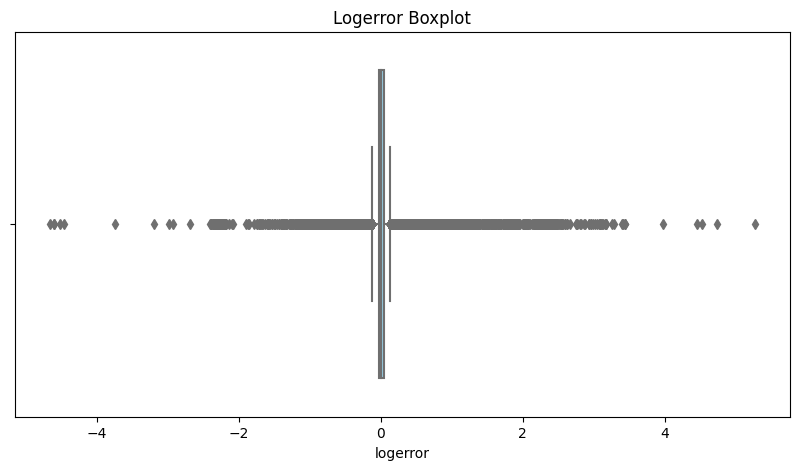

In [5]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["logerror"],color="skyblue")
plt.title("Logerror Boxplot")
plt.show()

In [6]:
df = df[(df["logerror"] > -3) & (df["logerror"] < 3)] # removing outliers

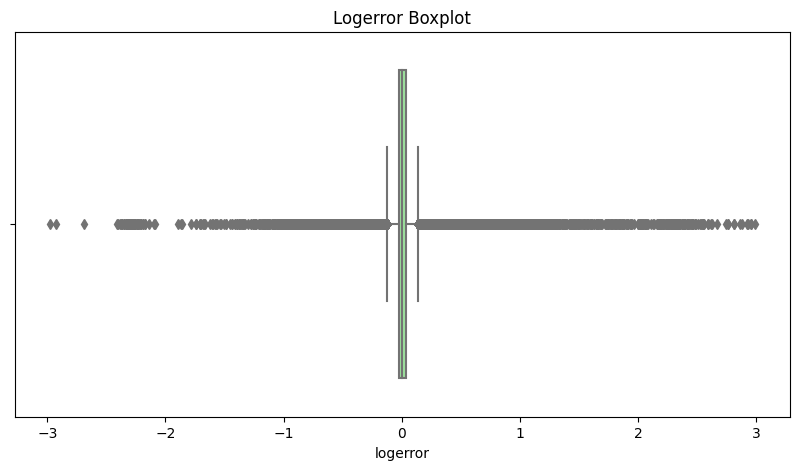

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df["logerror"],color="lightgreen")
plt.title("Logerror Boxplot")
plt.show()

In [8]:
# Drop columns with too many NaNs
missing_ratio = df.isnull().mean()
drop_cols = missing_ratio[missing_ratio > 0.8].index
df = df.drop(columns=drop_cols)

In [9]:
# Fill NaNs 
for col in df.columns:
    if df[col].dtype != "object":
        df[col] = df[col].fillna(df[col].median()) 
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

In [10]:
# Convert all categorical columns ( get_dummies for big dataset)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category").cat.codes

In [11]:
#  Feature Engineering
df['transactiondate'] = pd.to_datetime(df['transactiondate'])
df['trans_year'] = df['transactiondate'].dt.year
df['trans_month'] = df['transactiondate'].dt.month
df['trans_quarter'] = df['transactiondate'].dt.quarter
df.drop(columns=['transactiondate'], inplace=True)

df['bath_per_bed'] = df['bathroomcnt'] / (df['bedroomcnt']+1)
df['room_sum'] = df['bathroomcnt'] + df['bedroomcnt']
df['living_area_ratio'] = df['calculatedfinishedsquarefeet'] / (df['lotsizesquarefeet']+1)
df['value_per_sqft'] = df['taxvaluedollarcnt'] / (df['calculatedfinishedsquarefeet']+1)

cols = ["lotsizesquarefeet", "calculatedfinishedsquarefeet", "taxvaluedollarcnt"]
for col in cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])

In [12]:
# Drop parcelid
if "parcelid" in df.columns:
    df = df.drop(columns=["parcelid"])

In [13]:
# Ensure no NaN/inf
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [14]:
X = df.drop(columns=["logerror"])
y = df["logerror"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled_full = scaler.fit_transform(X)

In [17]:
print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Shapes: (134287, 41) (33572, 41) (134287,) (33572,)


In [18]:
results = {}

In [19]:
# LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
lin_preds = lin_reg.predict(X_test_scaled)

In [20]:
# Ridge
ridge_params = {"alpha": np.logspace(-3, 2, 20)}
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, scoring="neg_mean_absolute_error", cv=5)
ridge_cv.fit(X_train_scaled, y_train)
ridge_preds = ridge_cv.predict(X_test_scaled)

In [21]:
# Lasso
lasso_params = {"alpha": np.logspace(-4, 1, 20)}
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, lasso_params, scoring="neg_mean_absolute_error", cv=5)
lasso_cv.fit(X_train_scaled, y_train)
lasso_preds = lasso_cv.predict(X_test_scaled)

In [22]:
lr_mae = mean_absolute_error(y_test,lin_preds)
ridge_mae = mean_absolute_error(y_test,ridge_preds)
lasso_mae = mean_absolute_error(y_test,lasso_preds)

In [23]:
print("Linear Regression MAE :",lr_mae)
print("Ridge MAE :",ridge_mae,"with alpha =",ridge_cv.best_params_["alpha"])
print("Lasso MAE :",lasso_mae,"with alpha =",lasso_cv.best_params_["alpha"])

mae_scores = {
    "Linear Regression": lr_mae,
    "Ridge": ridge_mae,
    "Lasso": lasso_mae
}

best_model = min(mae_scores,key=mae_scores.get)
print("\nBest Model :",best_model,"with MAE =",mae_scores[best_model])

Linear Regression MAE : 0.06782785600920638
Ridge MAE : 0.06782061318932636 with alpha = 100.0
Lasso MAE : 0.06754796430640359 with alpha = 0.00206913808111479

Best Model : Lasso with MAE = 0.06754796430640359


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


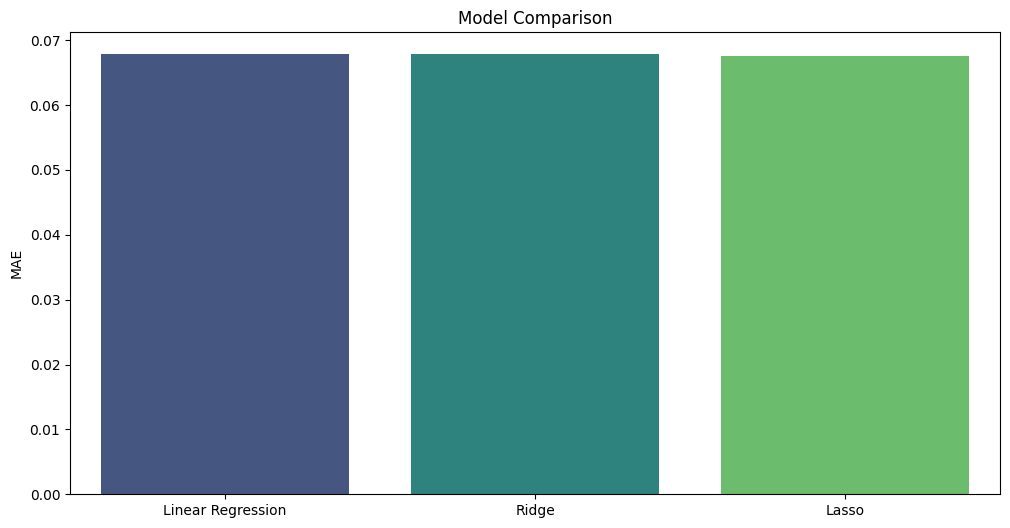

In [24]:
# MAE comparison Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(mae_scores.keys()),y=list(mae_scores.values()),palette="viridis")
plt.ylabel("MAE")
plt.title("Model Comparison")
plt.show()

In [25]:
if best_model == "LinearRegression":
    best_model_fitted = lin_preds
    y_pred_test = lin_preds
elif best_model == "Ridge":
    best_model_fitted = ridge_cv
    y_pred_test = ridge_preds
else:
    best_model_fitted = lasso_cv
    y_pred_test = lasso_preds

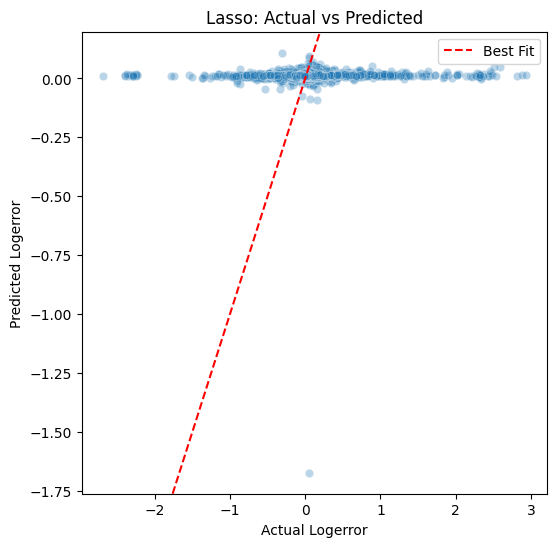

In [26]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test,y=y_pred_test,alpha=0.3)
plt.xlabel("Actual Logerror")
plt.ylabel("Predicted Logerror")
plt.title(f"{best_model}: Actual vs Predicted")
plt.axline((0,0),slope=1,color="red",linestyle="--",label="Best Fit")
plt.legend()
plt.show()

In [27]:
X_submit = prop_2017.copy()

In [28]:
parcel_ids = X_submit["parcelid"].values

In [29]:
X_submit = X_submit.drop(columns=drop_cols, errors="ignore")

In [30]:
X_submit['bath_per_bed'] = X_submit['bathroomcnt']/(X_submit['bathroomcnt']+1)
X_submit['room_sum'] = X_submit['bathroomcnt'] + X_submit['bathroomcnt']
X_submit['living_area_ratio'] = X_submit['calculatedfinishedsquarefeet']/(X_submit['lotsizesquarefeet']+1)
X_submit['value_per_sqft'] = X_submit['taxvaluedollarcnt']/(X_submit['calculatedfinishedsquarefeet']+1)

In [31]:
# Encode categoricals
for col in X_submit.select_dtypes(include="object").columns:
    X_submit[col] = X_submit[col].astype("category").cat.codes

In [32]:
X_submit = X_submit.drop(columns=["parcelid"],errors="ignore")

In [33]:
X_submit = X_submit.reindex(columns=X.columns,fill_value=0)

In [34]:
for col in X_submit.columns:
    if X_submit[col].dtype in [np.float64,np.int64]:
        X_submit[col] = X_submit[col].fillna(df[col].median())
    else:
        X_submit[col] = X_submit[col].fillna(0)

In [35]:
X_submit_scaled = scaler.transform(X_submit)

In [36]:
if best_model == "Linear Regression":
    best_model_fitted = lin_reg
elif best_model == "Ridge":
    best_model_fitted = ridge_cv.best_estimator_
else:
    best_model_fitted = lasso_cv.best_estimator_

In [37]:
preds = best_model_fitted.predict(X_submit_scaled)

In [38]:
for col in sample_submission.columns[1:]:
    sample_submission[col] = preds

In [39]:
sample_submission.to_csv("zillow_submission_new1.csv", index=False)
print("Submission file saved as zillow_submission.csv")

Submission file saved as zillow_submission.csv


In [40]:
# !kaggle competitions submit -c zillow-prize-1 -f zillow_submission.csv -m "Best model: {best_model_name}"